## Utilizing a Keras LSTM model to forecast henry hub natural gas price trends

### Imports/initial data

In [ ]:
pip install keras
pip install tensorflow

In [214]:
# Imports/Initial Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Import necessary libraries
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

In [215]:
from fredapi import Fred

# Initialize the API client with your FRED API key
api_key = "2d144ec6abaf01c598bc81bcec31fc00"  # Replace with your FRED API key
fred = Fred(api_key=api_key)

# Download the Henry Hub natural gas price data
series_id = "DHHNGSP"  # Series ID for Henry Hub natural gas price
data = fred.get_series(series_id)

# Print the downloaded data
print(data.head())

1997-01-07    3.82
1997-01-08    3.80
1997-01-09    3.61
1997-01-10    3.92
1997-01-13    4.00
dtype: float64


In [216]:
data = data.dropna()
data.shape

(6633,)

In [217]:
data_test = data.loc['2022':'2023']
data_train = data.loc[:'2021']

print(data_test.shape)
print(data_train.shape)

(348,)
(6285,)


In [218]:
data = np.array(data)
data_train = np.array(data_train)
data_test = np.array(data_test)

data = np.reshape(data, (data.shape[0], 1))
data_train = np.reshape(data_train, (data_train.shape[0], 1))
data_test = np.reshape(data_test, (data_test.shape[0], 1))
print(data.shape,data_train.shape,data_test.shape)

(6633, 1) (6285, 1) (348, 1)


### Data Normalization

In [219]:
# Data Normalilzation
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
training_set_scaled = sc.fit_transform(data_train)

In [220]:
training_set_scaled.shape

(6285, 1)

### Incorporating timesteps into data

In [221]:
X_train = []
y_train = []
for i in range(60, training_set_scaled.shape[0]):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [222]:
X_train.shape

(6225, 60, 1)

In [223]:
y_train.shape

(6225,)

## MLP

In [224]:
model_mlp = Sequential()
model_mlp.add(Dense(units = 50, input_shape = (X_train.shape[1],)))
model_mlp.add(Dropout(0.2))
model_mlp.add(Dense(units = 50))
model_mlp.add(Dropout(0.2))
model_mlp.add(Dense(units=1))
model_mlp.compile(optimizer = 'adam', loss = 'mean_squared_error')
model_mlp.fit(X_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10
195/195 [==============================] - 1s 2ms/step - loss: 0.0063
Epoch 2/10
195/195 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 3/10
195/195 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 4/10
195/195 [==============================] - 0s 2ms/step - loss: 0.0013
Epoch 5/10
195/195 [==============================] - 0s 2ms/step - loss: 0.0011
Epoch 6/10
195/195 [==============================] - 0s 2ms/step - loss: 9.1151e-04
Epoch 7/10
195/195 [==============================] - 0s 2ms/step - loss: 9.5637e-04
Epoch 8/10
195/195 [==============================] - 0s 1ms/step - loss: 8.3155e-04
Epoch 9/10
195/195 [==============================] - 0s 2ms/step - loss: 7.6212e-04
Epoch 10/10
195/195 [==============================] - 0s 2ms/step - loss: 6.4807e-04


In [228]:
inputs = data[len(data) - len(data_test) - 60:]

inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))
predicted_ng_price_mlp = model_mlp.predict(X_test)
predicted_ng_price_mlp = sc.inverse_transform(predicted_ng_price_mlp)

11/11 [==============================] - 0s 2ms/step


### Plotting the results

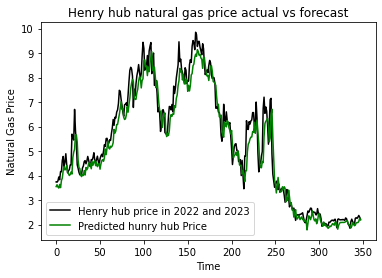

In [233]:
plt.plot(data_test, color = 'black', label = 'Henry hub price in 2022 and 2023')

plt.plot(predicted_ng_price_mlp, color = 'green', label = 'Predicted hunry hub Price')

plt.title('Henry hub natural gas price actual vs forecast')
plt.xlabel('Time')
plt.ylabel('Natural Gas Price')
plt.legend()
plt.show()

### Performance evaluation criteria

In [234]:
y_true = data_test
y_pred = predicted_ng_price_mlp
# MAE(Mean Absolute Error)
mae = sum(abs(y_true - y_pred)) / len(y_true)

# MSE(Mean Square Error)
mse = sum((y_true - y_pred)**2) / len(y_true)

# RMSE(Root Mean Square Error)
rmse = np.sqrt(mse)

# MAPE(Mean Absolute Percentage Error)
mape = sum(abs((y_true - y_pred)/y_true)) / len(y_true)

print(mae)
print(mse)
print(rmse)
print(mape)

[0.39911761]
[0.29765807]
[0.54558049]
[0.07528914]


## LSTM

In [236]:
model_lstm = Sequential()
model_lstm.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1],1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units = 50, return_sequences = True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units = 50, return_sequences = True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1))
model_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')
model_lstm.fit(X_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10
195/195 [==============================] - 23s 82ms/step - loss: 0.0019
Epoch 2/10
195/195 [==============================] - 16s 80ms/step - loss: 0.0011
Epoch 3/10
195/195 [==============================] - 14s 74ms/step - loss: 9.5264e-04
Epoch 4/10
195/195 [==============================] - 15s 78ms/step - loss: 8.9709e-04
Epoch 5/10
195/195 [==============================] - 15s 75ms/step - loss: 7.8680e-04
Epoch 6/10
195/195 [==============================] - 15s 75ms/step - loss: 7.8679e-04
Epoch 7/10
195/195 [==============================] - 14s 74ms/step - loss: 7.2083e-04
Epoch 8/10
195/195 [==============================] - 15s 76ms/step - loss: 6.6718e-04
Epoch 9/10
195/195 [==============================] - 15s 75ms/step - loss: 6.4389e-04
Epoch 10/10
195/195 [==============================] - 15s 77ms/step - loss: 6.2621e-04


In [253]:
inputs = data[len(data) - len(data_test) - 60:]

inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
predicted_ng_price_lstm = model_lstm.predict(X_test)
predicted_ng_price_lstm = sc.inverse_transform(predicted_ng_price_lstm)

11/11 [==============================] - 0s 21ms/step


### Plotting the results

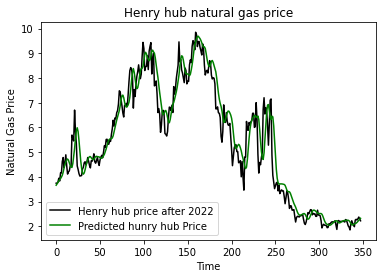

In [254]:
plt.plot(data_test, color = 'black', label = 'Henry hub price after 2022')

plt.plot(predicted_ng_price_lstm, color = 'green', label = 'Predicted hunry hub Price')

plt.title('Henry hub natural gas price')
plt.xlabel('Time')
plt.ylabel('Natural Gas Price')
plt.legend()
plt.show()

### Performance evaluation criteria

In [255]:
y_true = data_test
y_pred = predicted_ng_price_lstm
# MAE(Mean Absolute Error)
mae = sum(abs(y_true - y_pred)) / len(y_true)

# MSE(Mean Square Error)
mse = sum((y_true - y_pred)**2) / len(y_true)

# RMSE(Root Mean Square Error)
rmse = np.sqrt(mse)

# MAPE(Mean Absolute Percentage Error)
mape = sum(abs((y_true - y_pred)/y_true)) / len(y_true)

print(mae)
print(mse)
print(rmse)
print(mape)

[0.44478372]
[0.39728456]
[0.63030513]
[0.08793515]


Even though I should have tried various hyperparameters with different layers, with the result from the above code, MLP performs slightly better than LSTM.